# Inferencia Bayesiana con métodos Monte Carlo: Cadenas de Markov

## Problema 1

Se comienza leyendo y graficando los datos pertenecientes a la función de luminosidad de galaxias obtenida por Blanton et al (2001).

In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import random

In [2]:
sns.set()

In [3]:
#exporto columnas
M = np.genfromtxt('datos2.dat', delimiter=',', usecols=0) #magnitud
f = np.genfromtxt('datos2.dat', delimiter=',', usecols=1) #frecuencia (es el fi)

In [4]:
#errores
e_in = np.genfromtxt('errores_inferiores.dat', delimiter=',', usecols=1) #puntos inferiores
e_su = np.genfromtxt('errores_superiores.dat', delimiter=',', usecols=1) #puntos superiores

In [5]:
#largo de las barras de error
d_in = f - e_in  #inferior
d_su = e_su - f  #superior

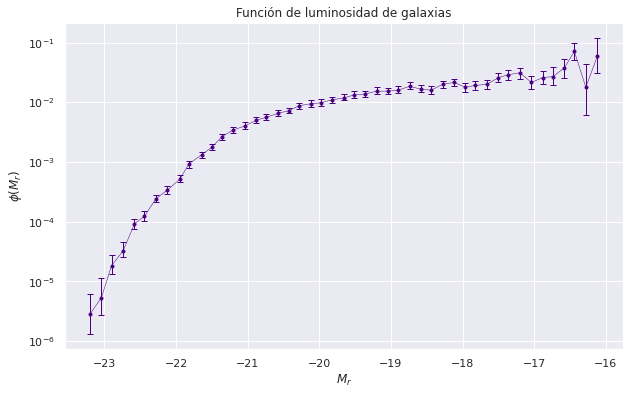

In [6]:
plt.figure(figsize=(10,6))
plt.errorbar(M, f, yerr= (d_in, d_su), marker='o', markersize=3, color='indigo', ecolor='indigo', elinewidth=1, linewidth=0.5)
plt.plot(M,e_in, '_', color='indigo')
plt.plot(M,e_su, '_', color='indigo')

plt.yscale('log')
plt.title('Función de luminosidad de galaxias')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.show()

## Problema 2

En este inciso se desea ajustar el modelo de la función de Schechter al conjunto de datos del problema 1, la cual es:

$$\phi(M)dM=0.4 ln(10) \phi_* 10^{-0.4(M-M_*)(\alpha+1)} exp(-10^{-0.4(M-M_*)})dM$$

donde los parámetros que se quieren determinar son $\phi_*$ , $M_∗$ y $\alpha$. 

Se realizará una inferencia Bayesiana para obtener el ajuste del modelo paramétrico a los datos, que como el nombre lo indica, la inferencia estadı́stica se lleva a cabo como una aplicación del teorema de Bayes. 

Si se tiene un conjunto de datos $d$ que se puede describir por un modelo $m$ con parámetros $\phi$, se quiere calcular el mejor modelo que puede dar lugar a esos datos, es decir, maximizar la probabilidad posterior de los parámetros dados los datos para un modelo, $p(\phi|d, m)$. Ésta probabilidad se puede escribir gracias al Teorema de Bayes, como:

$$p(\phi|d, m)=\frac{p(d|\phi,m)p(\phi|m)}{p(d|m)}$$

donde $p(d|\phi,m)$ es el Likelihood, $p(\phi|m)$ la función distribución de la probabilidad anterior (prior) y $p(d|m)$ la evidencia.

En este caso como el modelo $m$ está fijo, se tiene:

$$p(\phi|d)=p(d|\phi)p(\phi)$$


Se realizará una exploración del espacio multidimensional de parámetros para estimar la función de Likelihood usando Cadenas de Markov Monte Carlo (MCMC), implementadas por medio del algoritmo de Metrópolis-Hastings.

Se comienza realizando la función 'model' con la fórmula de Schechter, donde se renombran los parámetros de la forma: $\phi_*=fi0$ , $M_∗=M0$ y $\alpha=a$. Para verificarlo se lo grafica con los parámetros encontrados por Blanton et al. 2001, junto con los datos.

In [7]:
#modelo
def model(M,fi0,M0,a):
    lista=[]
    for i in range(len(M)):
        y=0.4 * log(10) * fi0 * (10**(-0.4*(M[i]-M0)*(a+1))) * exp(-10**(-0.4*(M[i]-M0))) #schechter
        lista.append(y)
    return lista

In [8]:
#rango de M
sx = np.linspace(-23.5, -16, 100) #podria usarse min(M), max(M)

#valores de Blanton
sy = model(sx, fi0=0.0146, M0=-20.83, a=-1.2)

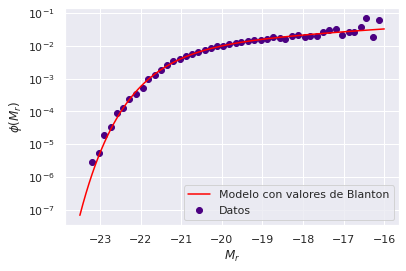

In [9]:
#los grafico con los datos
plt.plot(sx,sy, color='red', label='Modelo con valores de Blanton')
plt.scatter(M, f, color='indigo', label='Datos')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.legend(loc='lower right')
plt.show()

### Likelihood

La función de likelihood indica qué tan bien reproducen los datos a las predicciones del modelo.Se tiene:

$$p(d|\phi)=p({[x_i]}_{i=1}^N | \phi_*,M_*, \alpha) = \prod_{i=1}^{N} p((M_i, \phi_i) | \phi_*,M_*, \alpha)$$

Para calcular cada $ p((M_i, \phi_i) | \phi_*,M_*, \alpha)$ se asumen errores gaussianos. Para calcularlo, para cada dato $M_r$ medido, se evalua la frecuencia $\phi_i (=f)$ de los datos en una gaussiana centrada en el punto predicho por el modelo con parámetros fijos y sigma igual a la mitad del largo del ancho de las líneas de error.

Se realiza la siguiente función.

In [10]:
#sigmas de las gaussianas
sigma= (e_su - e_in)/2

In [11]:
def likelihood(M, f, fi0, M0, a, sigma):
    f_model = model(M,fi0,M0,a)
    
    #gaussiana centrada en el f(o fi) del modelo y sigma definido arriba:
    prob= st.norm(f_model, sigma).pdf(f) #evaluo en f, es VECTORIAL
    
    #las multiplico a todas:
    like=prob.prod()
    return like

In [12]:
#prueba con los valores de Blanton
likelihood(M,f,0.0146,-20.83,-1.2,sigma)

4.529434606468913e+121

In [13]:
#pruba con otros valores
likelihood(M,f,0.02,-21,-1,sigma)

1.3041787540153151e-238

A medida que los puntos medidos se acerquen más a los valores predichos por el modelo, es likelihood es mayor.

### Priors

Para la probabilidad a priori de los parámetros se toma una distribución plana, asumiendo que no se conoce nada de los parámetros. Por lo que esta función devuelve un valor constante si se encuentra dentro de la región que se va a muestrear, mientras que es nula fuera de la región. 

Para elegir los límites en los parámetros, se prueban distintos valores y se los compara con los datos.
Se nota que $\phi_*$ mueve el modelo hacia arriba/abajo, $M_*$ la subida de la función en el eje de las magnitudes y $\alpha$ la pendiente de la parte lineal.

Como los parámetros no son independientes entre si, para ver si los límites que se proponen son razonables y no quedan puntos medidos fuera de ellos, se consideran todos los modelos extremos dados por esos parámetros límites.

A continuación se grafican para mostrar que los parámetros elegidos no cortan los datos.

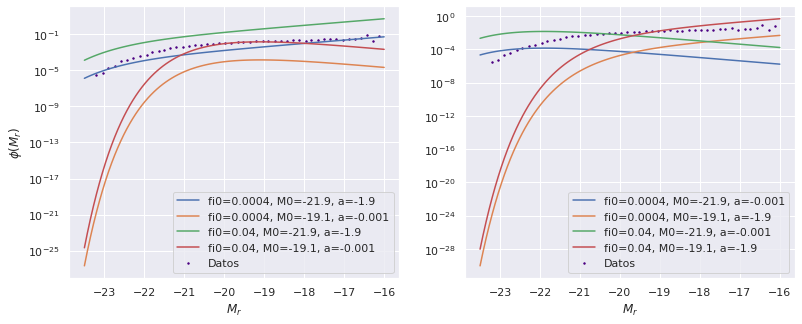

In [52]:
#grafico el modelo con distintos parámetros junto con los datos
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)   #figura con 2 filas y 2 columnas
plt.plot(sx,model(sx, fi0=0.0004, M0=-21.9, a=-1.9), label='fi0=0.0004, M0=-21.9, a=-1.9')
plt.plot(sx,model(sx, fi0=0.0004, M0=-19.1, a=-0.001), label='fi0=0.0004, M0=-19.1, a=-0.001')
plt.plot(sx,model(sx, fi0=0.04, M0=-21.9, a=-1.9), label='fi0=0.04, M0=-21.9, a=-1.9')
plt.plot(sx,model(sx, fi0=0.04, M0=-19.1, a=-0.001),  label='fi0=0.04, M0=-19.1, a=-0.001')
plt.scatter(M, f, color='indigo', s=2, label='Datos')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')

plt.subplot(1,2,2)
plt.plot(sx,model(sx, fi0=0.0004, M0=-21.9, a=-0.001), label='fi0=0.0004, M0=-21.9, a=-0.001')
plt.plot(sx,model(sx, fi0=0.0004, M0=-19.1, a=-1.9), label='fi0=0.0004, M0=-19.1, a=-1.9')
plt.plot(sx,model(sx, fi0=0.04, M0=-21.9, a=-0.001), label='fi0=0.04, M0=-21.9, a=-0.001')
plt.plot(sx,model(sx, fi0=0.04, M0=-19.1, a=-1.9), label='fi0=0.04, M0=-19.1, a=-1.9')
plt.scatter(M, f, color='indigo', s=2, label='Datos')
plt.legend(loc='lower right')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.show()

Así se ve que el modelo evaluado en los parámetros extremos abarca el rango donde se encuentran los datos. Luego, los límites que se toman para los parámetros son:

$$\phi_*=fi0=[0.0004, 0.04]$$

$$M_*=M0=[-21.9, -19.1]$$

$$\alpha=a=[-1.9, -0.001]$$


Esta elección también estuvo influenciada por como se veían las cadenas de Markov una vez formadas, tratando de elegir rangos pequeños cerca del valor esperado para que ocurra la convergencia de las mismas.

Se contruye la función prior:

In [15]:
#prior plano
def prior(fi0,M0,a):
    p=st.uniform(loc=[0.0004, -21.9, -1.9], scale=[0.0396, 2.8, 1.899])  #defino el cubo donde es constante
    r=p.pdf([fi0,M0,a]) #evaluo en el punto
    i=r.prod()   #los multiplico
    return i

Para ver si funciona:

In [16]:
#prueba con los valores de Blanton
prior(0.0146,-20.83,-1.2)

4.749214859799378

In [17]:
#prueba con otros valores
prior(0.0146,-20.83,-2)

0.0

### Función de probabilidad posterior

Se usa el teorema de Bayes visto anteriormente:

In [18]:
def posterior(M, f, fi0, M0, a, sigma=sigma):    
    pos= likelihood(M,f,fi0,M0,a,sigma) * prior(fi0,M0,a)
    return(pos)

In [19]:
#Prueba con Blanton
posterior(M, f, fi0=0.0146, M0=-20.83, a=-1.2, sigma=sigma)

2.151125813953171e+122

In [20]:
#Prueba con otros valores
posterior(M, f, fi0=2.9E-2, M0=-20.83, a=-1.2, sigma=sigma)

4.06705e-319

Se puede ver que para los valores de Blanton la probabilidad posterior es muy alta, y a medida que uno se aleja de estos valores la probabilidad posterior disminuye.

## Proposal

La proposal distribution es lo que se propone para el salto de parámetros. Se asume una distribución gaussiana centrada en el paso anterior y el sigma depende del parámetro ya que debe ser el indicado para que los saltos tengan el tamaño adecuado. Se la define de la siguiente forma.

In [21]:
import functools

In [22]:
#sigmas
sig_fi0= 0.00002 
sig_M0=0.002
sig_a=0.002

proposal=functools.partial(np.random.multivariate_normal, cov = [[sig_fi0, 0 , 0], [0, sig_M0, 0], [0,0,sig_a]])

### MCMC

Se realizan las cadenas, que se pueden pensar como saltos (en 3 dimensiones), cuyo nuevo paso está dado por la función proposal evaluada en el paso anterior. Se calcula la probabilidad de aceptación como el mínimo entre 1 y la razón (función posterior en el paso nuevo)/(función posterior en el paso anterior). Se genera un número aleatorio 'u' entre 0 y 1, y si u es menor a la probabilidad de aceptacion se acepta el paso.

Para elegir los parámetros iniciales de la cadena se sortean inicialmente en el rango que se definió el prior, y se le pide que elija aquellos valores que no anulen la función posterior.

In [23]:
#CADENA
post=0
while post < (1.e-8): #es como un for
    #quiero que sea un punto adentro del cubo
    fi0_inic=random.uniform(0.0004, 0.04)
    M0_inic=random.uniform(-21.9, -19.1)
    a_inic=random.uniform(-1.9, -0.001)

    post= posterior(M, f, fi0_inic, M0_inic, a_inic) #evaluo posterior en los parametros iniciales

#listas donde guardo los pasos
cadena_fi0= [fi0_inic]
cadena_M0= [M0_inic]
cadena_a= [a_inic]
posteriores=[post]
n_pasos=5000

for i in range(n_pasos):
    fi0_new, M0_new, a_new= proposal([fi0_inic, M0_inic, a_inic])

    post_new= posterior(M, f, fi0_new, M0_new, a_new) #posterior nueva

    prob_aceptacion= min(1, post_new/post)
    u=random.random()
    
    if u < prob_aceptacion : #condcion para aceptar el punto
        fi0_inic= fi0_new
        M0_inic= M0_new
        a_inic= a_new
        post=post_new
            
    cadena_fi0.append(fi0_inic)
    cadena_M0.append(M0_inic)
    cadena_a.append(a_inic)
    posteriores.append(post)

Los factores que intervinieron principalmente en las cadenas son: el ancho de los intervalos de los parámetros (priors), los sigmas dados en la proposal (pasos) y el número de pasos. Estos valores cambiaban mucho la forma de las cadenas, por lo que dificultó la tarea de elegir los correctos ya que se necesita de cierta intuición para realizarlo. Es necesario llegar a un balance entre el tamaño del salto y el ancho del intervalo, recordando que no debe ser demasiado grande ya que a grandes distancias la función posterior es nula (por el likelihood y prior), ni tampoco demasiado chico (se necesita más tiempo de cómputo o nunca llega al valor esperado).

Luego de muchos intentos, a prueba y error y gracias a la ayuda de todos nuestros compañeros se logran realizar las cadenas. Para comprobar si las cadenas muestrean correctamente y para comprobar su convergencia, se realizan distintos gráficos.

- Parámetro vs parámetro:

Text(0, 0.5, 'alfa')

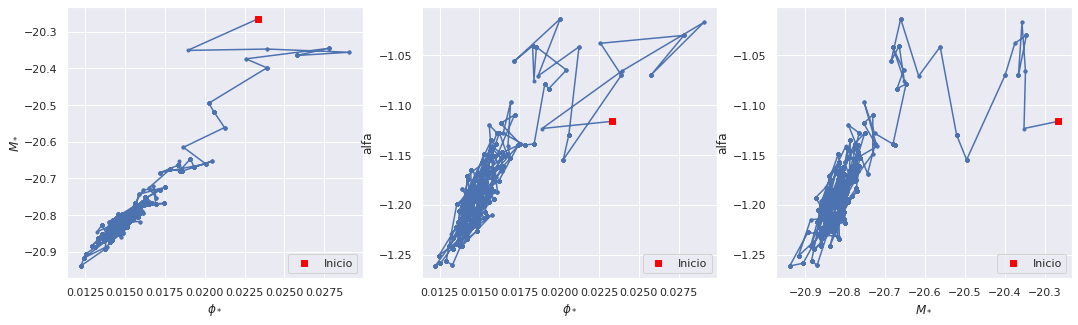

In [24]:
#parametros vs parametros
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(cadena_fi0, cadena_M0, marker='.')
plt.plot(cadena_fi0[0], cadena_M0[0], 's', color='red', label='Inicio') #parametros de inicio
plt.legend(loc='lower right')
plt.xlabel('$\phi_*$')
plt.ylabel('$M_*$')

plt.subplot(1,3,2)
plt.plot(cadena_fi0, cadena_a, marker='.')
plt.plot(cadena_fi0[0], cadena_a[0], 's', color='red', label='Inicio')
plt.legend(loc='lower right')
plt.xlabel('$\phi_*$')
plt.ylabel('alfa')

plt.subplot(1,3,3)
plt.plot(cadena_M0, cadena_a, marker='.')
plt.plot(cadena_M0[0], cadena_a[0], 's', color='red', label='Inicio')
plt.legend(loc='lower right')
plt.xlabel('$M_*$')
plt.ylabel('alfa')

Al ver los gráficos obtenidos se nota que en los 3 casos, desde el lugar en donde se comienza la cadena, los saltos empiezan a realizar un "camino" hasta que se agrupan en un sector y quedan oscilando a su alrededor. Este sector donde se acumulan está centrado aproximadamente en los valores obtenidos por Blanton.

- Parámetro en función de los pasos:

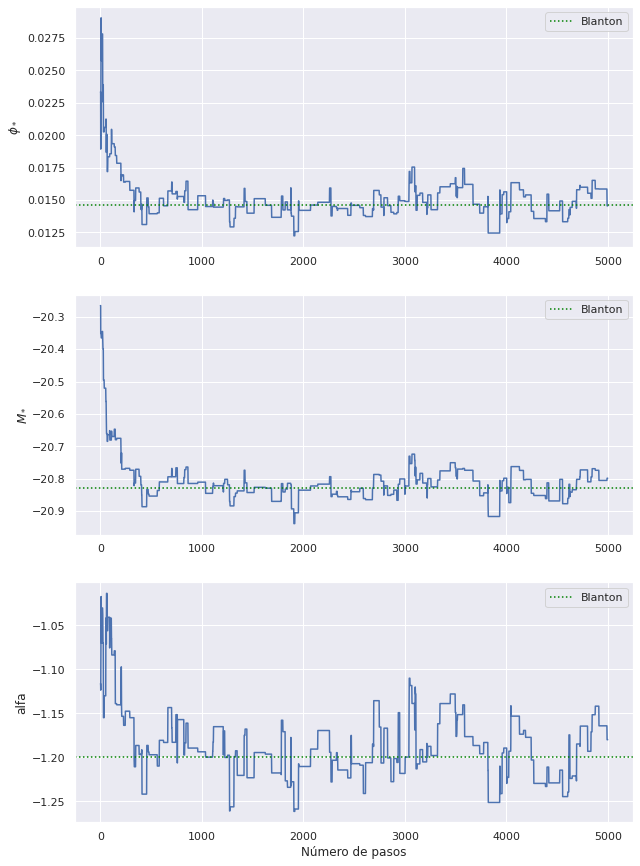

In [28]:
#en funcion de los pasos
plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
plt.plot(cadena_fi0)
plt.axhline(0.0146, color='green', label='Blanton', ls="dotted") #valor esperado
plt.legend(loc='upper right')
plt.ylabel('$\phi_*$')

plt.subplot(3,1,2)
plt.plot(cadena_M0)
plt.axhline(-20.83, color='green', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.ylabel('$M_*$')

plt.subplot(3,1,3)
plt.plot(cadena_a)
plt.axhline(-1.2, color='green', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('Número de pasos')
plt.ylabel('alfa')
plt.show()

Al graficar las cadenas de esta forma se puede ver que al comienzo hay un perı́odo donde las condiciones iniciales son importantes llamado “burn-in" (aproximadamente hasta el paso 500), antes de la convergencia de la cadena. Estos valores deben eliminarse. Luego de este "quemado" de la cadena, los valores quedan oscilando alrededor de un valor constante, que como se puede ver es similar al valor esperado.

- Histogramas:

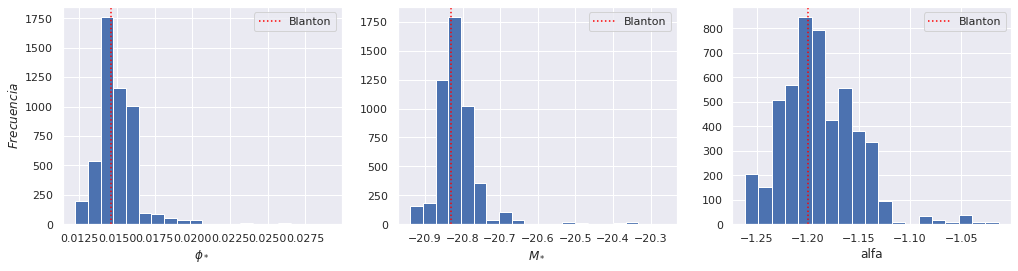

In [41]:
#Histogramas
plt.figure(figsize=(17,4))
plt.subplot(1,3,1)
plt.hist(cadena_fi0, 'doane')
plt.axvline(0.0146, color='red', label='Blanton', ls="dotted") #valor esperado
plt.legend(loc='upper right')
plt.xlabel('$\phi_*$')
plt.ylabel('$Frecuencia$')

plt.subplot(1,3,2)
plt.hist(cadena_M0, 'doane')
plt.axvline(-20.83, color='red', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('$M_*$')

plt.subplot(1,3,3)
plt.hist(cadena_a, 'doane')
plt.axvline(-1.2, color='red', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('alfa')
plt.show()

Se puede ver que la distribución de los parámetros obtenidas presenta un pico que coincide con los valores esperados. Se notan algunos valores lejos de los esperados pero tienen una frecuencia muy baja, posiblemente pertenecientes a la etapa del quemado de la cadena.

Para obtener el parámetro buscado, se estima el valor de expectación (promedio) con los parámetros obtenidos con los valores una vez que la cadena converge. Si bien graficamente parecería que el quemado ocurre aproximadamente en el paso número 500, se deja una "zona de seguridad" luego de este paso y se toma como valor de quemado a n=1000 para tomar un rango más confiable.

In [42]:
#corto las cadenas a partir de 1000 (quemado)
n_quemado=1000
quemado_fi0=cadena_fi0[1000:]
quemado_M0=cadena_M0[1000:]
quemado_a=cadena_a[1000:]

In [45]:
#promedio
prom_fi0=np.mean(quemado_fi0)
prom_M0=np.mean(quemado_M0)
prom_a=np.mean(quemado_a)

print('fi0=',prom_fi0)
print('M0=',prom_M0)
print('a=',prom_a)

fi0= 0.014731544933340413
M0= -20.82513604492872
a= -1.194905730459823


Se ve que los valores obtenidos son similares a los de Blanton, por lo que la cadena sería un buen estimador de los parámetros y está cumpliendo con lo que se quería. En el proximo punto se realizan varias cadenas y se vuelven a calcular estos valores.

## Problema 3

Se quiere visualizar las propiedades de convergencia de varias cadenas, para ello se realizarán 5 cadenas y luego se grafican los parámetros en función de los pasos.

In [46]:
cadenas_fi0=[] #aca se van a guardar as nuevas cadenas
cadenas_M0=[]
cadenas_a=[]

for j in range(5):
    post2=0
    while post2 < (1.e-8): #es como un for
        fi0_inic2=random.uniform(0.0004, 0.04)
        M0_inic2=random.uniform(-21.9, -19.1)
        a_inic2=random.uniform(-1.9, -0.001)
        post2= posterior(M, f, fi0_inic2, M0_inic2, a_inic2) #evaluo en los parametros iniciales
    
    cadena_fi02= [fi0_inic2]
    cadena_M02= [M0_inic2]
    cadena_a2= [a_inic2]
    #posteriores=[post]
    n_pasos2=5000
    
    for i in range(n_pasos2):
        fi0_new2, M0_new2, a_new2= proposal([fi0_inic2, M0_inic2, a_inic2])
        post_new2= posterior(M, f, fi0_new2, M0_new2, a_new2) 
        
        prob_aceptacion2= min(1, post_new2/post2)
        u2=random.random()
        if u2 < prob_aceptacion2 : #condcion para aceptar el punto
            fi0_inic2= fi0_new2
            M0_inic2= M0_new2
            a_inic2= a_new2
            post2=post_new2
        cadena_fi02.append(fi0_inic2)
        cadena_M02.append(M0_inic2)
        cadena_a2.append(a_inic2)
        #posteriores.append(post)
    
    cadenas_fi0.append(cadena_fi02)
    cadenas_M0.append(cadena_M02)
    cadenas_a.append(cadena_a2)
    

Text(0, 0.5, 'alfa')

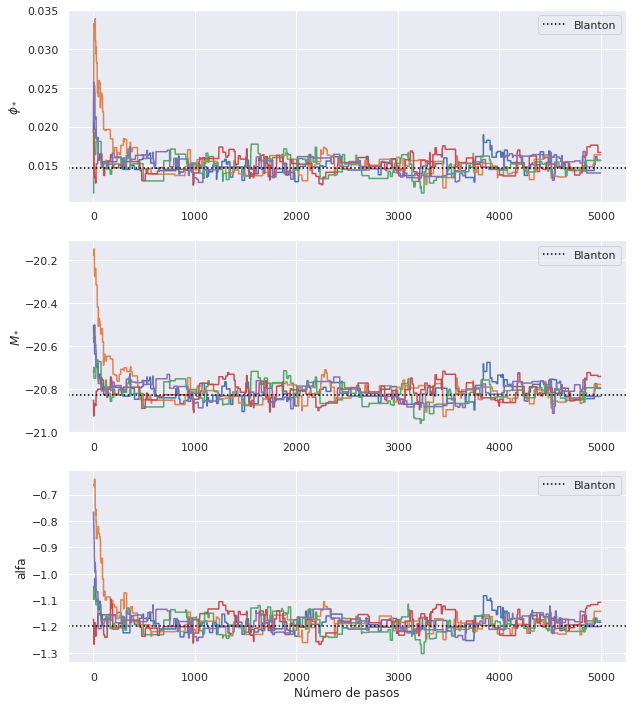

In [47]:
#graficos
plt.figure(figsize=(10,12))

plt.subplot(3,1,1)
plt.plot(cadenas_fi0[0])
plt.plot(cadenas_fi0[1])
plt.plot(cadenas_fi0[2])
plt.plot(cadenas_fi0[3])
plt.plot(cadenas_fi0[4])
plt.axhline(0.0146, color='black', label='Blanton', ls="dotted") #valor esperado
plt.legend(loc='upper right')
plt.ylabel('$\phi_*$')

plt.subplot(3,1,2)
plt.plot(cadenas_M0[0])
plt.plot(cadenas_M0[1])
plt.plot(cadenas_M0[2])
plt.plot(cadenas_M0[3])
plt.plot(cadenas_M0[4])
plt.axhline(-20.83, color='black', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.ylabel('$M_*$')

plt.subplot(3,1,3)
plt.plot(cadenas_a[0])
plt.plot(cadenas_a[1])
plt.plot(cadenas_a[2])
plt.plot(cadenas_a[3])
plt.plot(cadenas_a[4])
plt.axhline(-1.2, color='black', label='Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('Número de pasos')
plt.ylabel('alfa')

Al visualizar las cadenas se nota que todas ellas convergen alrededor del mismo valor (los esperados). Se vuelve a notar el "quemado" aproximadamente a los 500 pasos, pero para el calculo de los promedios se considera a partir del paso 1000.

In [48]:
#promedios considerando a partir de 1000 (quemado)
promedios_fi0=[] #listas con los promedios de cada cadena
promedios_M0=[]
promedios_a=[]

for i in range(5): #numero de cadenas
    quema_fi0=cadenas_fi0[i][1000:]
    quema_M0=cadenas_M0[i][1000:]
    quema_a=cadenas_a[i][1000:]
    
    prom_fi0=np.mean(quema_fi0)
    prom_M0=np.mean(quema_M0)
    prom_a=np.mean(quema_a)
    
    promedios_fi0.append(prom_fi0)
    promedios_M0.append(prom_M0)
    promedios_a.append(prom_a)

In [49]:
fi0_encontrado=np.mean(promedios_fi0)
print('El valor encontrado para el parámetro fi0 es:', fi0_encontrado)

M0_encontrado=np.mean(promedios_M0)
print('El valor encontrado para el parámetro M0 es:', M0_encontrado)

a_encontrado=np.mean(promedios_a)
print('El valor encontrado para el parámetro a es:', a_encontrado)

El valor encontrado para el parámetro fi0 es: 0.014921989547592019
El valor encontrado para el parámetro M0 es: -20.81852306263669
El valor encontrado para el parámetro a es: -1.1899358438783563


Se grafica el modelo de Schechter con estos parámetros junto con los datos iniciales para ver como se comportan:

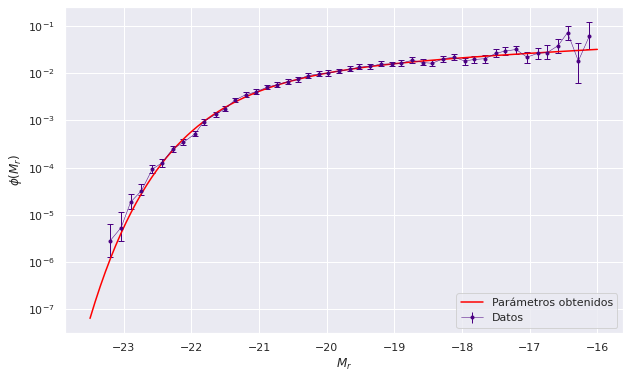

In [54]:
plt.figure(figsize=(10,6))
#datos con errores
plt.errorbar(M, f, yerr= (d_in, d_su), marker='o', markersize=3, color='indigo', ecolor='indigo', elinewidth=1, linewidth=0.5, label='Datos')
plt.plot(M,e_in, '_', color='indigo')
plt.plot(M,e_su, '_', color='indigo')
#mis parámetros:
plt.plot(sx,model(sx, fi0=0.01492, M0=-20.82, a=-1.19), color='red', label='Parámetros obtenidos')

plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.legend(loc='lower right')
plt.show()

Al observar el grafico se ve que los valores obtenidos ajustan bien a los puntos, cayendo dentro de las barras de error de la mayoría de ellos.

Por otro lado, al comparar los valores con los que obtuvieron Blanton et al. 2001, los encontrados con las cadenas caen dentro del error estimado por ellos, por lo que el método fue efectivo para encontrar los parámetros que ajustan a la función.

## Conclusiones

Los métodos Bayesianos, frecuentemente implementados usando las Cadenas de Markov Monte Carlo (MCMC), proveen una manera poderosa de estimar los parámetros de un modelo realizando un muestreo aleatorio del espacio de parámetros.

En este caso se logró ajustar la función de Schechter a la función de luminosidad de galaxias obtenida por Blanton et al. 2001 por medio de la implementación del algoritmo Metrópolis-Hastings para llevar a cabo realizaciones de MCMC.

Los parámetros encontrados son: 

$$\phi_* = 0.01492, M_*=-20.82, \alpha=-1.19$$

los cualesajustan bien a los datos y pertenecen al intervalo de parámetros encontrados por Blanton et al. 2001.